# Systematic impacts of word onsets on word concreteness

Do the sounds in a word impact its meaning? 

In [another notebook](http://localhost:8888/notebooks/concreteness_impacts.ipynb), I showed that the first character of a word *can* have predictable effects on its concreteness. Here, I repeat this analysis, but with phonetic representations of words (using [PhonDISC](http://groups.linguistics.northwestern.edu/speech_comm_group/documents/CELEX/Phonetic%20codes%20for%20CELEX.pdf)). 

In [2]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sn

# Operations
import numpy as np
import pandas as pd 
import statsmodels.formula.api as sm
from tqdm import tqdm

# Custom imports
from nlp_utilities.compling import CorpusUtilities
from src.utils import get_concreteness_for_word




In [3]:
# Set global variables
DATA_PATH = "data/raw/mrc_concreteness.csv"
CHARACTER_INDEX	= 0

# Get data
df = pd.read_csv(DATA_PATH, sep="\t")
df['Word'] = df['Word'].str.lower()

# Rescale concreteness
df['Concreteness'] = df['Concreteness'] / 100

# Drop duplicates
df = df.drop_duplicates(subset="Word")
print("Number of words left in MRC: {num}".format(num=len(df)))

# Merge with celex
df_celex = pd.read_csv("data/raw/celex_all.csv", sep = "\\")
df_celex = df_celex.drop_duplicates(subset='Word')
print("Number of words in CELEX: {num}".format(num=len(df_celex)))

# Merge together to get phonetic representations
df_merged = df_celex.merge(df, on="Word")
print("Number of words in both MRC and CELEX: {num}".format(num=len(df_merged)))

# Drop duplicate phonetic representations (homophones)
df_merged = df_merged.drop_duplicates(subset = 'PhonDISC')
print("Number of words left: {num}".format(num=len(df_merged)))

# Get minimal sets
print("Getting minimal sets...")
minimal_sets = CorpusUtilities.get_minimal_orthographic_sets(df_merged['PhonDISC'], index=CHARACTER_INDEX)
print("Number of minimal sets: {num}".format(num=len(minimal_sets)))

  0%|          | 0/3947 [00:00<?, ?it/s]

Number of words left in MRC: 4293
Number of words in CELEX: 46133
Number of words in both MRC and CELEX: 4136
Number of words left: 3947
Getting minimal sets...


100%|██████████| 3947/3947 [01:25<00:00, 45.93it/s] 


In [4]:
# Calculate onset impact
onset_to_impact = []
for set_index, ms in tqdm(list(enumerate(minimal_sets))):
	letters = [w[CHARACTER_INDEX] for w in ms]
	by_word_cnc = get_concreteness_for_word(ms, df_merged, column='PhonDISC')
	mean_cnc = np.mean(by_word_cnc)
	for index, onset in enumerate(letters):
		to_add = [onset, by_word_cnc[index] - mean_cnc, mean_cnc, ms[index], set_index]
		onset_to_impact.append(to_add)

COLUMNS = ['onset', 'concreteness_impact', 'set_mean', 'original_word', 'set_index']
final_df = pd.DataFrame(onset_to_impact, columns=COLUMNS)



100%|██████████| 412/412 [00:01<00:00, 219.61it/s]


## Analysis

Now we look at whether particular onsets have systematic impacts on the concreteness of the words in which they appear.

In [5]:
result = sm.ols(formula="concreteness_impact ~ onset", data=final_df).fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     concreteness_impact   R-squared:                       0.077
Model:                             OLS   Adj. R-squared:                  0.051
Method:                  Least Squares   F-statistic:                     2.984
Date:                 Tue, 13 Nov 2018   Prob (F-statistic):           5.67e-09
Time:                         13:51:27   Log-Likelihood:                -1851.9
No. Observations:                 1391   AIC:                             3782.
Df Residuals:                     1352   BIC:                             3986.
Df Model:                           38                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1653      0.351     -0.471      0.638      -0.854       0.524
onset[T.$]    -0.2640      0.497     -0.531      0.595      -1.238       0.710
onset[T.1]    -0.2689      0.481     -0.559      0.576      -1.212       0.675
onset[T.2]     1.2057      0.582      2.070      0.039       0.063       2.348
onset[T.3]     0.7997      0.641      1.247      0.213      -0.458       2.058
onset[T.4]     0.8924      0.745      1.198      0.231      -0.569       2.354
onset[T.5]     0.4027      0.449      0.896      0.370      -0.479       1.284
onset[T.6]     0.1581      0.745      0.212      0.832      -1.304       1.620
onset[T.7]     0.8615      0.745      1.156      0.248      -0.600       2.323
onset[T.8]     0.4465      0.745      0.599      0.549      -1.015       1.908
onset[T.@]    -0.7464      0.641     -1.164      0.245      -2.004       0.512
onset[T.D]    -1.8833      0.458     -4.112      0.000      -2.782      -0.985
onset[T.E]     0.2090      0.582      0.359      0.720      -0.934       1.352
onset[T.I]     0.1090      0.517      0.211      0.833      -0.905       1.123
onset[T.J]     0.5574      0.403      1.382      0.167      -0.234       1.349
onset[T.Q]     0.2631      0.544      0.483      0.629      -0.804       1.331
onset[T.S]     0.3283      0.387      0.849      0.396      -0.430       1.087
onset[T.T]    -0.1874      0.397     -0.472      0.637      -0.967       0.592
onset[T.V]    -0.0931      0.517     -0.180      0.857      -1.107       0.921
onset[T._]     0.1834      0.388      0.473      0.636      -0.577       0.944
onset[T.b]     0.3475      0.363      0.959      0.338      -0.364       1.059
onset[T.d]     0.2132      0.368      0.579      0.563      -0.509       0.936
onset[T.f]     0.1168      0.364      0.320      0.749      -0.598       0.832
onset[T.g]     0.2187      0.375      0.584      0.559      -0.516       0.954
onset[T.h]     0.1072      0.367      0.292      0.770      -0.613       0.827
onset[T.i]     0.2051      0.517      0.397      0.692      -0.809       1.219
onset[T.j]     0.0740      0.430      0.172      0.863      -0.770       0.918
onset[T.k]     0.4917      0.362      1.358      0.175      -0.219       1.202
onset[T.l]     0.0892      0.366      0.244      0.808      -0.629       0.807
onset[T.m]    -0.0614      0.367     -0.167      0.867      -0.781       0.658
onset[T.n]    -0.1024      0.377     -0.272      0.786      -0.842       0.637
onset[T.p]     0.3279      0.364      0.902      0.367      -0.386       1.041
onset[T.r]     0.2091      0.366      0.572      0.568      -0.509       0.927
onset[T.s]     0.1434      0.364      0.393      0.694      -0.571       0.858
onset[T.t]     0.2503      0.366      0.684      0.494      -0.468       0.969
onset[T.v]     0.0609      0.401      0.152      0.879      -0.726    

In [6]:

### Shuffling
shuffled_rsquares = []
true_rsquare = result.rsquared

NUM_SHUFFLES = 1000

for shuffle in tqdm(range(NUM_SHUFFLES)):
    new_df = final_df.copy()
    new_df['shuffled_onset'] = np.random.permutation(new_df['onset'])
    new_result = sm.ols(formula="concreteness_impact ~ shuffled_onset", data=new_df).fit()
    shuffled_rsquares.append(new_result.rsquared)

100%|██████████| 1000/1000 [00:17<00:00, 55.67it/s]


In [7]:
p_real = len([r for r in shuffled_rsquares if r >= true_rsquare]) / len(shuffled_rsquares)
print("p={p}".format(p=p_real))

p=0.0


Text(0.5,1,'Real R^2 vs. distribution from random permutations')

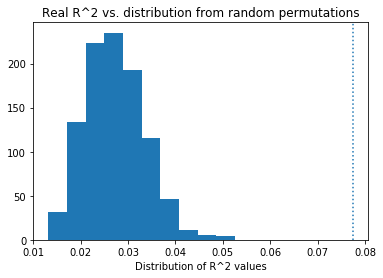

In [9]:
plt.hist(shuffled_rsquares)
plt.axvline(x=true_rsquare, linestyle="dotted")
plt.xlabel("Distribution of R^2 values")
plt.title("Real R^2 vs. distribution from random permutations")

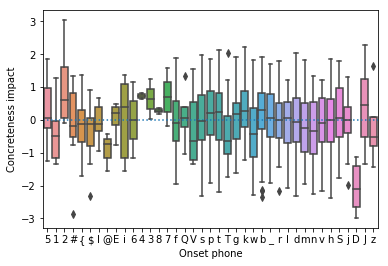

In [10]:
ax = sn.boxplot(data=final_df, x="onset", y="concreteness_impact")
ax.set(xlabel="Onset phone", ylabel="Concreteness impact")
ax.axhline(y=0, linestyle="dotted")

## Discussion and exploration)

Based on these results, it seems like:

First, there is more structure in mappings between phonetic onsets and word concreteness than one would expect by chance, one we control for characteristics about the rest of the word.

Certain onsets exhibit particularly strong effects, such as: 
- **/D/** (the onset in *they*) has a consistently *negative* impact on concreteness.
- **/2/** (the onset in *aisle* or *eye*) has a consistently *positive* impact on concreteness.

In [21]:
df_merged['initial'] = df_merged['PhonDISC'].apply(lambda x: x[0])

In [29]:
df_merged[df_merged['initial'] == "D"].sample(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial
3672,that,0.00,1,D{t,ADV,1,2.32,D
3701,those,2.95,1,D5z,PRON,1,2.54,D
3679,then,3.27,1,DEn,ADV,1,1.90,D
3716,thus,2.25,1,DVs,ADV,1,1.97,D
3677,them,3.37,1,DEm,PRON,1,3.44,D


In [24]:
df_merged[df_merged['initial'] == "2"].head(5)

,Word,CobLog,CompCnt,PhonDISC,Class,SylCnt,Concreteness,initial
83,aisle,1.00,1,2l,N,1,5.09,2
1264,eye,2.72,1,2,N,1,6.34,2
1265,eyrie,0.00,0,2@rI,N,3,5.29,2
1784,ice,1.72,1,2s,N,1,6.21,2
1785,icicle,0.00,0,2sIkP,N,3,5.69,2
